In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from scipy.stats import pearsonr, spearmanr

In [ ]:
MASTER = Path("../data/processed/master_teams_2000_2019.csv")
TAB_OUT = Path("../data/processed")
FIG_OUT = Path("../plots")
TAB_OUT.mkdir(parents=True, exist_ok=True)
FIG_OUT.mkdir(parents=True, exist_ok=True)
LATEX_OUT = Path("../latex/tables")
LATEX_OUT.mkdir(parents=True, exist_ok=True)

In [3]:
df = pd.read_csv(MASTER, parse_dates=["season_date"])
print("df head:")
df.head()

df head:


,yearID,lgID,teamID,franchID,name,G,W,L,R,RA,ERA,HR,RunDiff,logHR1,logERA,season_date,team_year
0,2000,AL,ANA,ANA,Anaheim Angels,162,82,80,864,869,5.00,236,-5,5.468060,1.791759,2000-07-01,ANA_2000
1,2001,AL,ANA,ANA,Anaheim Angels,162,75,87,691,730,4.20,158,-39,5.068904,1.648659,2001-07-01,ANA_2001
2,2002,AL,ANA,ANA,Anaheim Angels,162,99,63,851,644,3.69,152,207,5.030438,1.545433,2002-07-01,ANA_2002
3,2003,AL,ANA,ANA,Anaheim Angels,162,77,85,736,743,4.28,150,-7,5.017280,1.663926,2003-07-01,ANA_2003
4,2004,AL,ANA,ANA,Anaheim Angels,162,92,70,836,734,4.28,162,102,5.093750,1.663926,2004-07-01,ANA_2004


In [4]:
target = "W"
predictors = ["RunDiff", "ERA", "HR", "logHR1"]
cols_for_matrix = [target] + predictors

In [5]:
pearson_mat = df[cols_for_matrix].corr(method="pearson")
pearson_mat.to_csv(TAB_OUT / "corr_matrix_pearson.csv", float_format="%.6f")
print("pearson_mat:")
print(pearson_mat)

pearson_mat:
                W   RunDiff       ERA        HR    logHR1
W        1.000000  0.939502 -0.655431  0.392000  0.390141
RunDiff  0.939502  1.000000 -0.669011  0.408016  0.403803
ERA     -0.655431 -0.669011  1.000000  0.113466  0.119500
HR       0.392000  0.408016  0.113466  1.000000  0.990278
logHR1   0.390141  0.403803  0.119500  0.990278  1.000000


In [6]:
spearman_mat = df[cols_for_matrix].corr(method="spearman")
spearman_mat.to_csv(TAB_OUT / "corr_matrix_spearman.csv", float_format="%.6f")
print("spearman_mat:")
print(spearman_mat)

spearman_mat:
                W   RunDiff       ERA        HR    logHR1
W        1.000000  0.939825 -0.657467  0.385293  0.385293
RunDiff  0.939825  1.000000 -0.668832  0.397830  0.397830
ERA     -0.657467 -0.668832  1.000000  0.108070  0.108070
HR       0.385293  0.397830  0.108070  1.000000  1.000000
logHR1   0.385293  0.397830  0.108070  1.000000  1.000000


In [7]:
rows = []
for x in predictors:
    sub = df[[target, x]].dropna()
    r_p, p_p = pearsonr(sub[target], sub[x])
    r_s, p_s = spearmanr(sub[target], sub[x])
    rows.append(
        {
            "X": x,
            "pearson_r": r_p,
            "pearson_p": p_p,
            "spearman_rho": r_s,
            "spearman_p": p_s,
            "N": len(sub),
        }
    )

corr_wp = pd.DataFrame(rows).sort_values("pearson_r", ascending=False)
corr_wp.to_csv(TAB_OUT / "corr_W_vs_X.csv", index=False, float_format="%.6f")
print("corr w vs x:")
print(corr_wp)

corr w vs x:
         X  pearson_r      pearson_p  spearman_rho     spearman_p    N
0  RunDiff   0.939502  1.996439e-280      0.939825  4.226518e-281  600
2       HR   0.392000   1.784321e-23      0.385293   1.138430e-22  600
3   logHR1   0.390141   2.995635e-23      0.385293   1.138430e-22  600
1      ERA  -0.655431   6.250593e-75     -0.657467   1.530168e-75  600


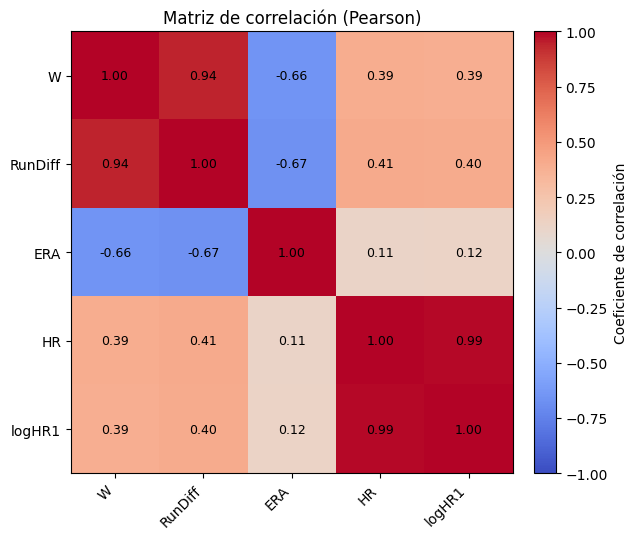

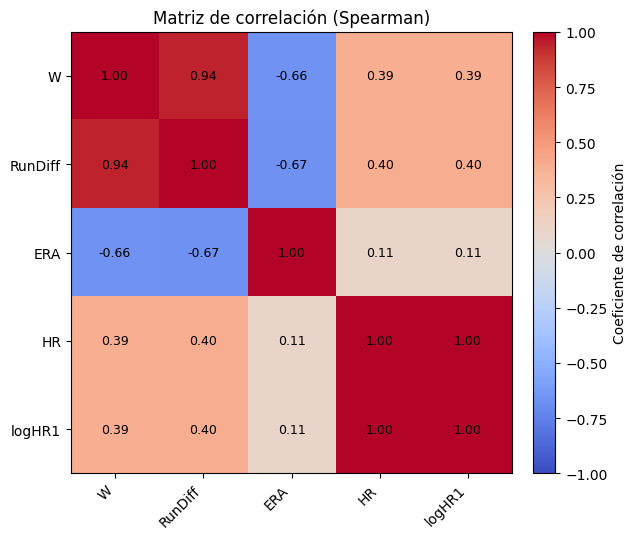

Heatmaps guardados en plots/


In [8]:
def plot_heatmap(mat: pd.DataFrame, title: str, outpath: Path):
    data = mat.values
    labels = mat.columns.tolist()

    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    im = ax.imshow(data, cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.text(j, i, f"{data[i, j]:.2f}", ha="center", va="center", fontsize=9)

    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Coeficiente de correlación", rotation=90)
    fig.tight_layout()
    fig.savefig(outpath, dpi=150, transparent=True)
    plt.show()
    plt.close(fig)


plot_heatmap(
    pearson_mat, "Matriz de correlación (Pearson)", FIG_OUT / "heatmap_corr_pearson.png"
)
plot_heatmap(
    spearman_mat,
    "Matriz de correlación (Spearman)",
    FIG_OUT / "heatmap_corr_spearman.png",
)
print("Heatmaps guardados en plots/")

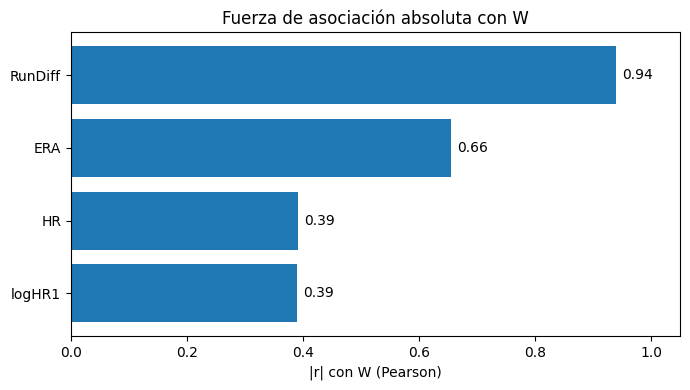

In [9]:
abs_r = corr_wp[["X", "pearson_r"]].copy()
abs_r["abs_pearson_r"] = abs_r["pearson_r"].abs()
abs_r = abs_r.sort_values("abs_pearson_r", ascending=True)

fig, ax = plt.subplots(figsize=(7, 4))
ax.barh(abs_r["X"], abs_r["abs_pearson_r"])
ax.set_xlabel("|r| con W (Pearson)")
ax.set_title("Fuerza de asociación absoluta con W")
for i, v in enumerate(abs_r["abs_pearson_r"]):
    ax.text(v + 0.01, i, f"{v:.2f}", va="center")
ax.set_xlim(0, 1.05)
fig.tight_layout()
fig.savefig(FIG_OUT / "bar_abs_r_W.png", dpi=150, bbox_inches="tight", transparent=True)
plt.show()
plt.close(fig)

In [ ]:
# try:
#     with open(LATEX_OUT / "corr_W_vs_X.tex", "w") as f:
#         f.write(
#             corr_wp.rename(
#                 columns={
#                     "X": "Variable",
#                     "pearson_r": "Pearson r",
#                     "pearson_p": "p (Pearson)",
#                     "spearman_rho": "Spearman $\\rho$",
#                     "spearman_p": "p (Spearman)",
#                     "N": "N",
#                 }
#             ).to_latex(
#                 index=False,
#                 float_format="%.4f",
#                 caption="Correlación de W con variables explicativas",
#                 label="tab:corr_w_x",
#             )
#         )
#     print("Tabla LaTeX exportada: data/processed/corr_W_vs_X.tex")
# except Exception as e:
#     print("No se exportó LaTeX (opcional). Razón:", e)

Tabla LaTeX exportada: data/processed/corr_W_vs_X.tex
